# Dive Prediction - Hidden Markov Model

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a HMM to predict seabirds' dives.

HMM' characteristics:

* *Number of modes* : 3

<div class="alert alert-info">
 ⚠️ Notebook using R
</div>

In [1]:
library(momentuHMM)
library(pracma)
library(lubridate)

momentuHMM 1.5.2 (2021-01-06)

Warning message in print.momentuHMM.version():
“  A newer version (1.5.4) is available from CRAN”

Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date




In [2]:
options(stringsAsFactors = FALSE)

path = "./results/SD_15s.csv"

data = read.table(path, sep = ',', header = TRUE)
data$datetime <- as.POSIXct(data$datetime, tz = 'GMT')

# Fit HMM

In [3]:
rawData <- data[,c("trip","lon","lat", "datetime", "dive", "gaps")]
colnames(rawData) <- c("ID", "lon", "lat", "datetime", "dive", "gaps")
birdData <- prepData(data=rawData, type = "LL", coordNames = c("lon", "lat"))


## 3 states with gaps

In [4]:
# parameters initialization
## cluster K-Means for initialization
### STEP
clusterBird_step <- kmeans(na.omit(data.frame(birdData$step)), 3)
muS_1 <- max(clusterBird_step$centers)
muS_2 <- median(clusterBird_step$centers) 
muS_3 <- min(clusterBird_step$centers) 
# muS_4 <- muS_3 
sdS_1 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == max(clusterBird_step$centers))])
sdS_2 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == median(clusterBird_step$centers))])
sdS_3 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == min(clusterBird_step$centers))])
# sdS_4 <- sdS_3 

### ANGLE
## for von mises
kappaA_1 <- 4
kappaA_2 <- 2
kappaA_3 <- 0.1
# kappaA_4 <- 4

### ZERO MASS
zeroMass <- length(which(birdData$step == 0))/nrow(birdData) #we need to include zeroMass parameters

### FIT MODEL
stateNames <- c("fly","observe", "dive")
dist = list(step = "gamma", angle = "vm")

anglePar0 <- c(kappaA_1, kappaA_2, kappaA_3) 
stepPar0 <- c(muS_1, muS_2, muS_3, sdS_1, sdS_2, sdS_3, zeroMass, zeroMass, zeroMass)

# formula for transition probabilities
formula <- ~ 1

In [5]:
m <- fitHMM(data = birdData, nbStates = 3, dist = dist,
            Par0 = list(step = stepPar0, angle = anglePar0), stateNames = stateNames,
            formula = formula)


Fitting HMM with 3 states and 2 data streams

-----------------------------------------------------------------------


 step ~ gamma(mean=~1, sd=~1, zeromass=~1)

 angle ~ vm(concentration=~1)


 Transition probability matrix formula: ~1


 Initial distribution formula: ~1


DONE



In [9]:
prob = stateProbs(m)
data$hmm = prob[, 'observe']

In [10]:
TP <- NULL
FP <- NULL
for (p in unique(data$hmm)){
    all_estim <- 1*(data$hmm > p)
    
    true_positive <- mean(all_estim[data$dive == 1])
    true_negative <- 1-mean(all_estim[data$dive == 0])
    
    TP <- c(TP,true_positive)
    FP <- c(FP,1-true_negative)
}

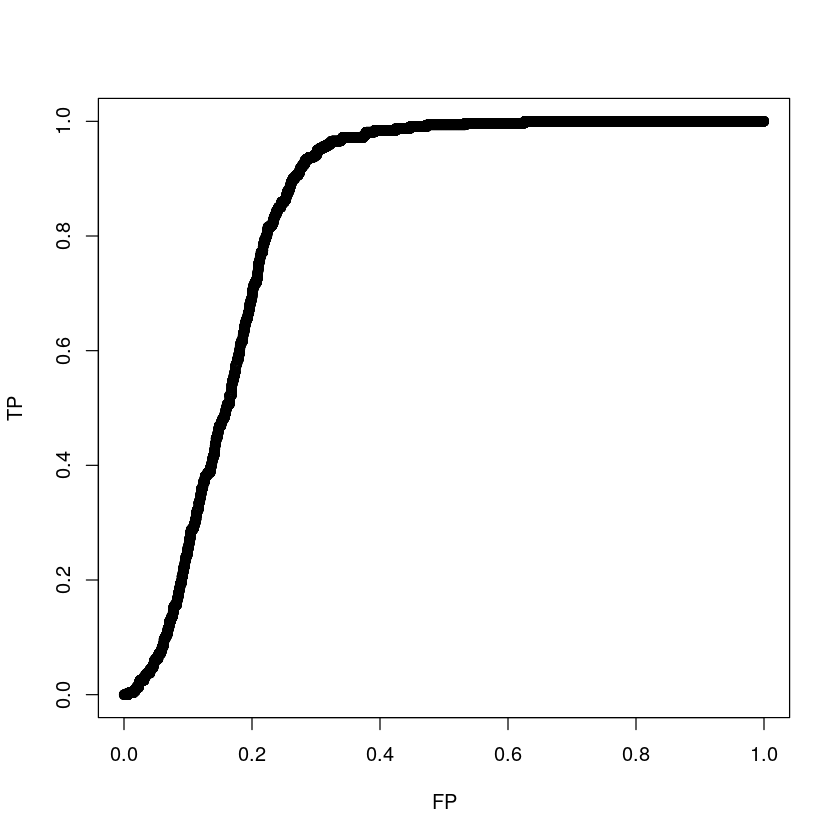

In [11]:
plot(FP,TP, xlim = c(0,1), ylim = c(0,1))

In [12]:
write.table(data, file = path, sep = ',', row.names = FALSE)